# Explore here

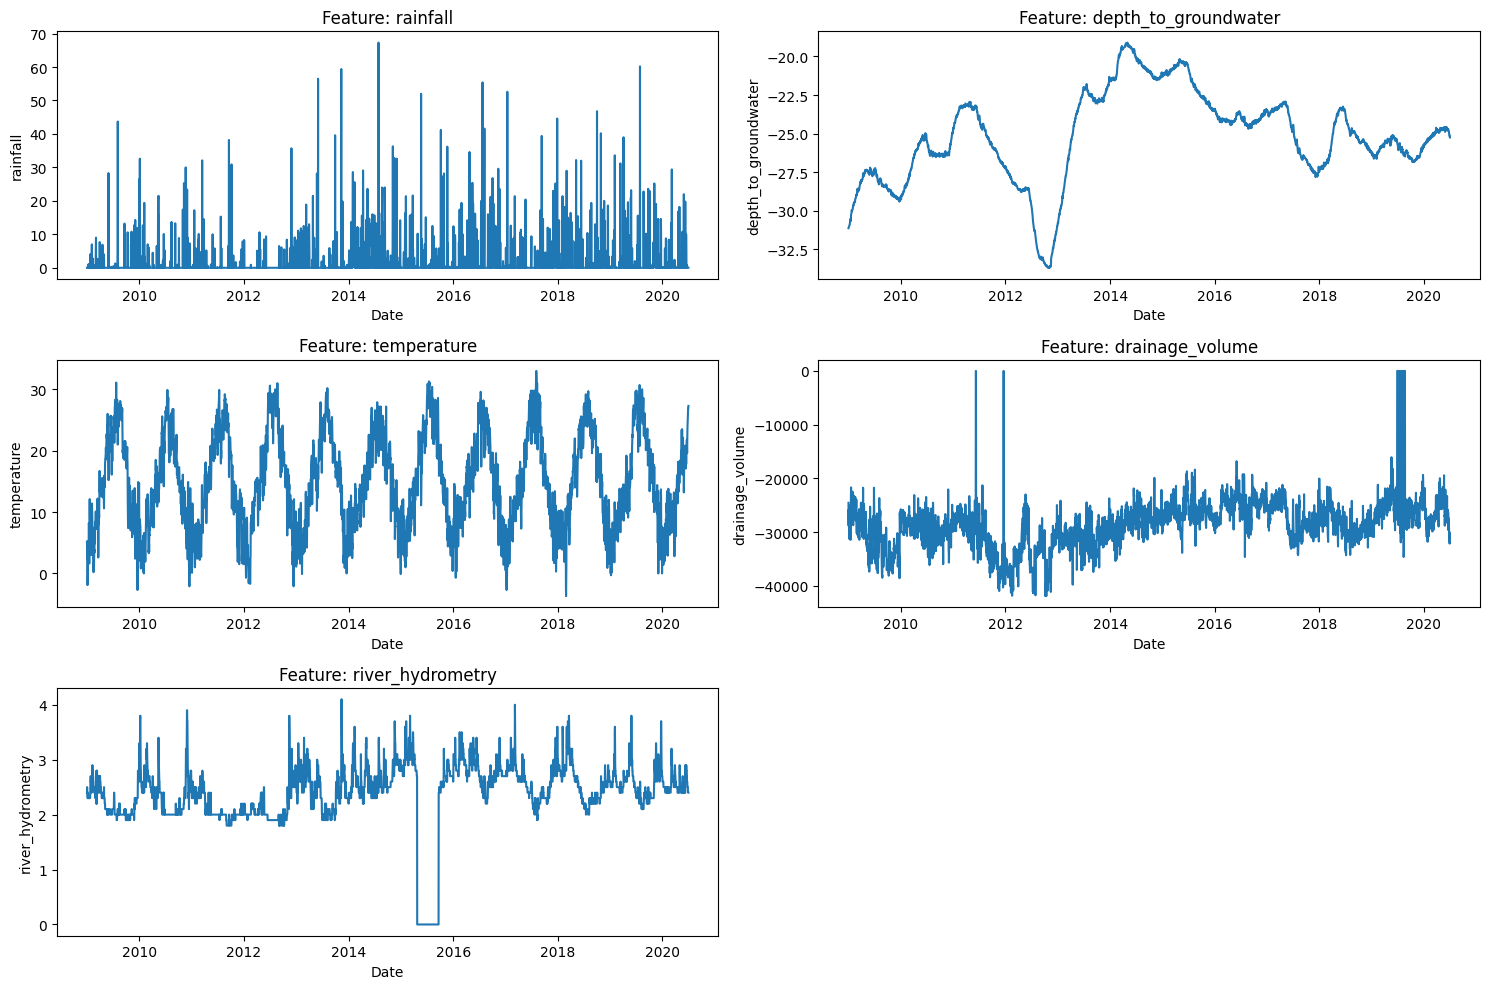

Epoch 1/20
208/208 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0411 - val_loss: 3.1123e-04
Epoch 2/20
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5.9368e-04 - val_loss: 3.0819e-04
Epoch 3/20
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4.3829e-04 - val_loss: 1.4886e-04
Epoch 4/20
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.5463e-04 - val_loss: 7.6479e-05
Epoch 5/20
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.3089e-04 - val_loss: 6.1870e-05
Epoch 6/20
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.0478e-04 - val_loss: 6.1127e-05
Epoch 7/20
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 9.1257e-05 - val_loss: 5.7073e-05
Epoch 8/20
208/208 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 1.0361e-04 - val_loss: 5.7464e-05
Epoch 9/20
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7.4498e-05 - val_loss: 9.5856e-05
Epoch 10/20
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 8.8512e-05 - val_loss: 2.1469e-04
Epoch 11/20
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 8.

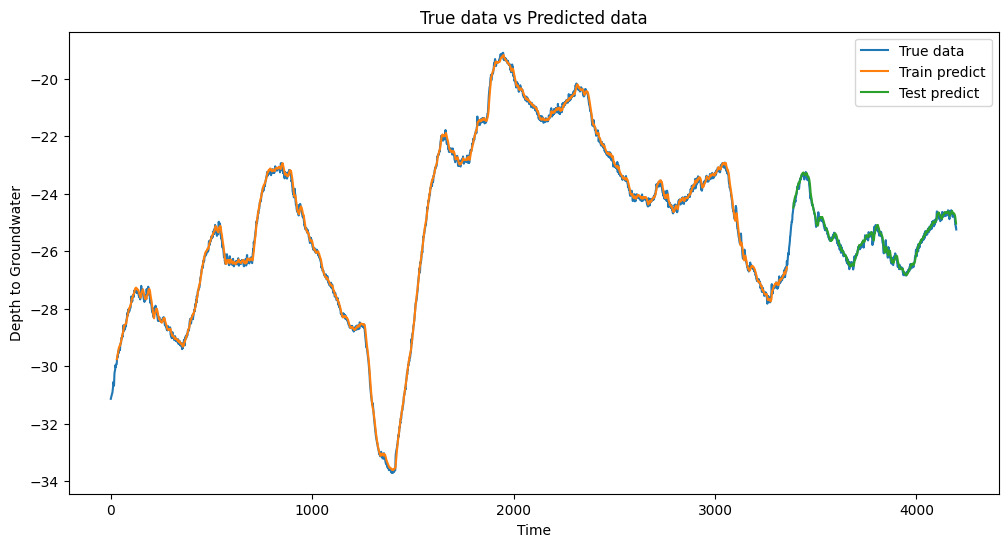

Train RMSE: 0.10
Test RMSE: 0.10


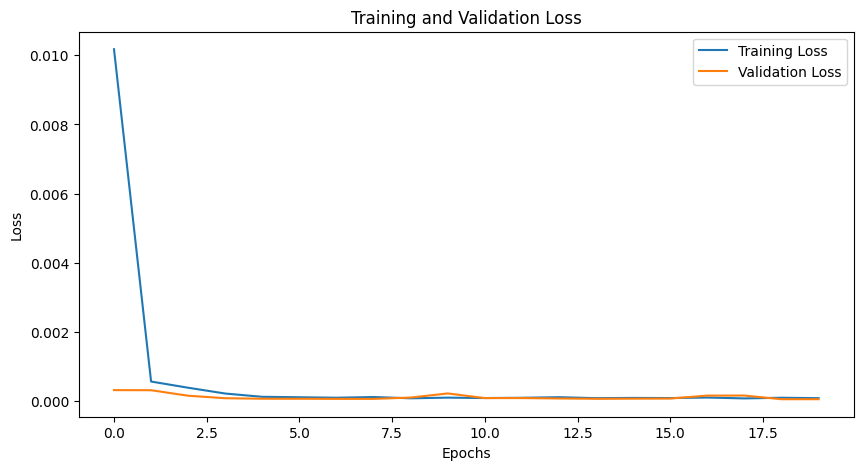

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

# Leer el dataset
file_path = '/workspace/An-lisis-inteligente-del-agua-de-Acea/data/raw/Aquifer_Petrignano.csv'
df = pd.read_csv(file_path)

# Eliminar filas con valores NaN en la columna de lluvia
df = df[df['Rainfall_Bastia_Umbra'].notna()].reset_index(drop=True)

# Seleccionar las columnas relevantes y simplificar nombres de columnas
df = df.drop(['Depth_to_Groundwater_P24', 'Temperature_Petrignano'], axis=1)
df.columns = ['date', 'rainfall', 'depth_to_groundwater', 'temperature', 'drainage_volume', 'river_hydrometry']

# Convertir la columna de fecha a formato datetime
df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y')

# Interpolar valores faltantes
df.interpolate(method='linear', inplace=True)

# Visualización inicial de las series temporales
features = ['rainfall', 'depth_to_groundwater', 'temperature', 'drainage_volume', 'river_hydrometry']
plt.figure(figsize=(15, 10))
for i, feature in enumerate(features):
    plt.subplot(3, 2, i+1)
    plt.plot(df['date'], df[feature])
    plt.title(f'Feature: {feature}')
    plt.xlabel('Date')
    plt.ylabel(feature)
plt.tight_layout()
plt.show()

# Escalar los datos
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df[['depth_to_groundwater']])

# Crear los conjuntos de entrenamiento y prueba
train_size = int(len(scaled_data) * 0.8)
test_size = len(scaled_data) - train_size
train, test = scaled_data[0:train_size, :], scaled_data[train_size:len(scaled_data), :]

# Función para crear dataset con look_back
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

# Crear dataset con look_back
look_back = 30
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)

# Redimensionar la entrada para ser [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

# Crear y entrenar el modelo LSTM
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(1, look_back)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

history = model.fit(X_train, y_train, epochs=20, batch_size=16, validation_data=(X_test, y_test))

# Predecir
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Invertir las predicciones
train_predict = scaler.inverse_transform(train_predict)
y_train = scaler.inverse_transform([y_train])
test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform([y_test])

# Crear el espacio para el gráfico de entrenamiento
train_predict_plot = np.empty_like(scaled_data)
train_predict_plot[:, :] = np.nan
train_predict_plot[look_back:len(train_predict) + look_back, :] = train_predict

# Crear el espacio para el gráfico de prueba
test_predict_plot = np.empty_like(scaled_data)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict) + (look_back * 2) + 1:len(scaled_data) - 1, :] = test_predict

# Graficar los datos
plt.figure(figsize=(12, 6))
plt.plot(scaler.inverse_transform(scaled_data), label='True data')
plt.plot(train_predict_plot, label='Train predict')
plt.plot(test_predict_plot, label='Test predict')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Depth to Groundwater')
plt.title('True data vs Predicted data')
plt.show()

# Calcular y mostrar RMSE
train_score = np.sqrt(mean_squared_error(y_train[0], train_predict[:, 0]))
test_score = np.sqrt(mean_squared_error(y_test[0], test_predict[:, 0]))
print(f'Train RMSE: {train_score:.2f}')
print(f'Test RMSE: {test_score:.2f}')

# Graficar la pérdida de entrenamiento y validación
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

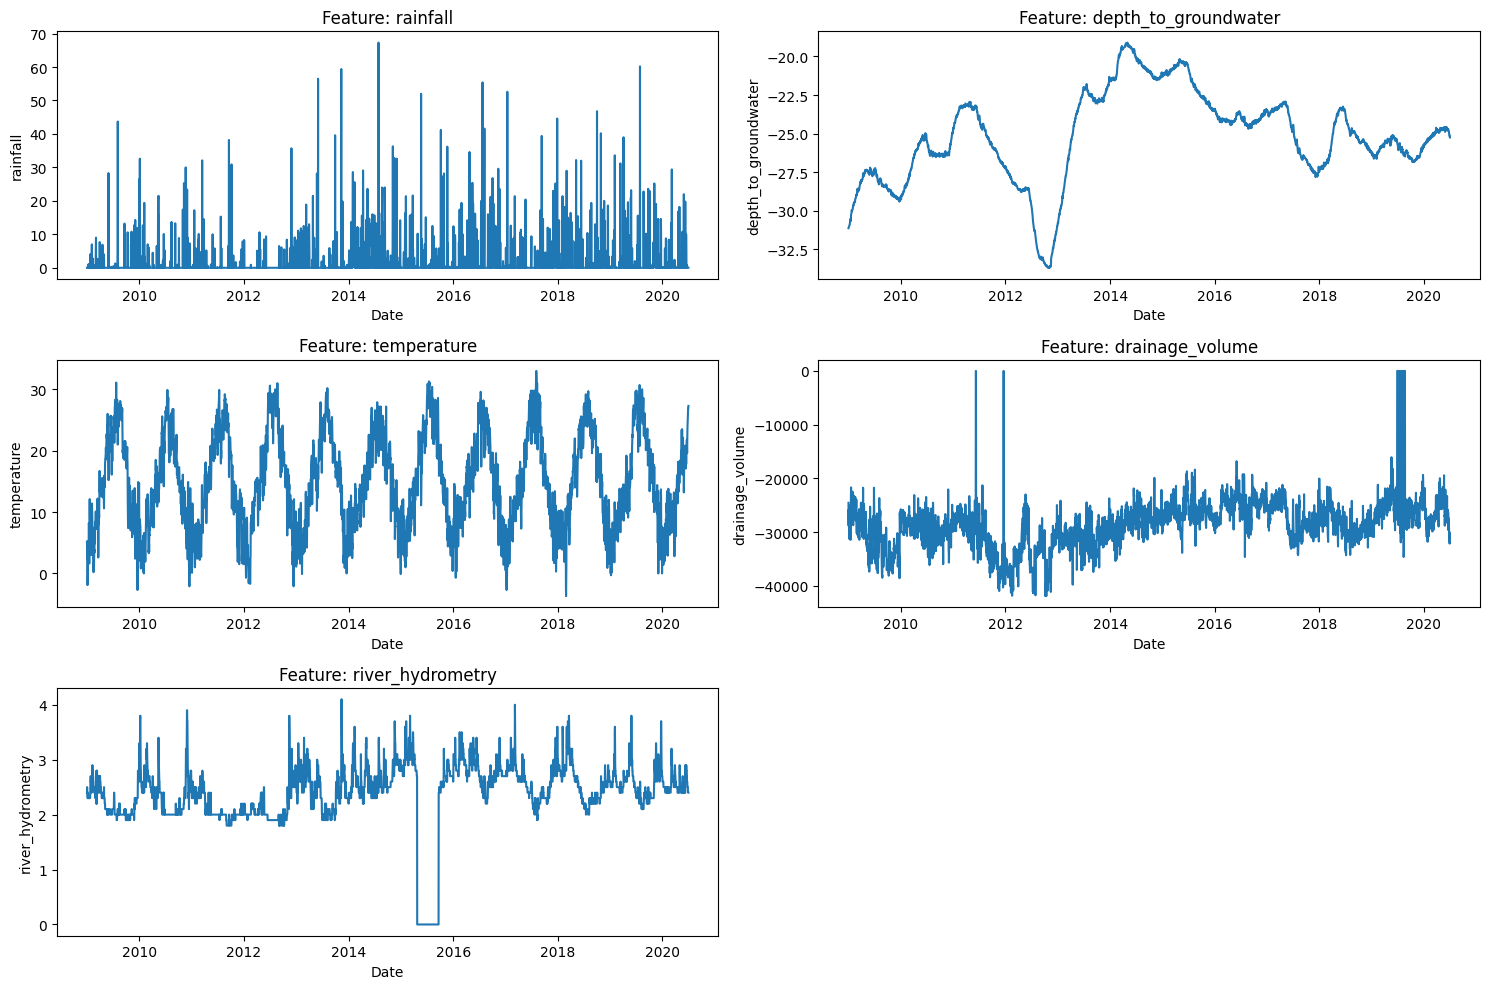

Epoch 1/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0685 - val_loss: 3.5603e-04
Epoch 2/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.4770e-04 - val_loss: 3.3011e-04
Epoch 3/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 6.0517e-04 - val_loss: 2.5331e-04
Epoch 4/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.7904e-04 - val_loss: 1.8308e-04
Epoch 5/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.0279e-04 - val_loss: 7.6939e-05
Epoch 6/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.3242e-04 - val_loss: 8.0756e-05
Epoch 7/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.2127e-04 - val_loss: 8.3560e-05
Epoch 8/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 9.2173e-05 - val_loss: 7.0105e-05
Epoch 9/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.7270e-05 - val_loss: 7.4542e-05
Epoch 10/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.9797e-05 - val_loss: 6.4805e-05
Epoch 11/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9

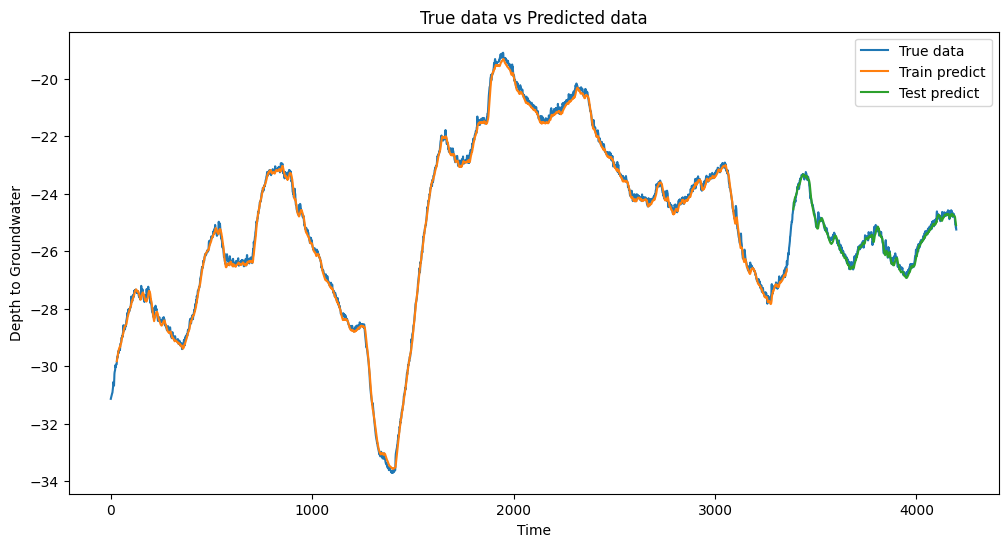

Train RMSE: 0.12
Test RMSE: 0.12


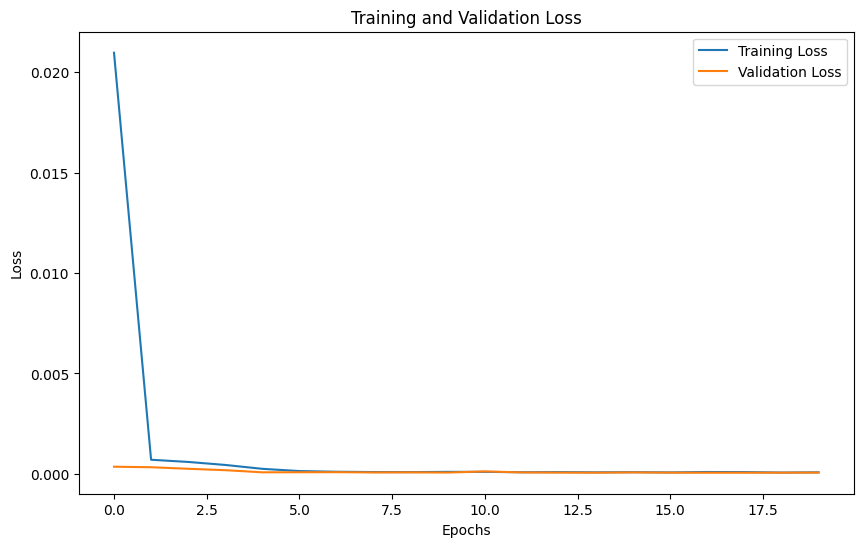

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

# Leer el dataset
file_path = '/workspace/An-lisis-inteligente-del-agua-de-Acea/data/raw/Aquifer_Petrignano.csv'
df = pd.read_csv(file_path)

# Eliminar filas con valores NaN en la columna de lluvia
df = df[df['Rainfall_Bastia_Umbra'].notna()].reset_index(drop=True)

# Seleccionar las columnas relevantes y simplificar nombres de columnas
df = df.drop(['Depth_to_Groundwater_P24', 'Temperature_Petrignano'], axis=1)
df.columns = ['date', 'rainfall', 'depth_to_groundwater', 'temperature', 'drainage_volume', 'river_hydrometry']

# Convertir la columna de fecha a formato datetime
df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y')

# Interpolar valores faltantes
df.interpolate(method='linear', inplace=True)

# Visualización de las características
plt.figure(figsize=(15, 10))
plt.subplot(3, 2, 1)
plt.plot(df['date'], df['rainfall'])
plt.title('Feature: rainfall')
plt.xlabel('Date')
plt.ylabel('rainfall')

plt.subplot(3, 2, 2)
plt.plot(df['date'], df['depth_to_groundwater'])
plt.title('Feature: depth_to_groundwater')
plt.xlabel('Date')
plt.ylabel('depth_to_groundwater')

plt.subplot(3, 2, 3)
plt.plot(df['date'], df['temperature'])
plt.title('Feature: temperature')
plt.xlabel('Date')
plt.ylabel('temperature')

plt.subplot(3, 2, 4)
plt.plot(df['date'], df['drainage_volume'])
plt.title('Feature: drainage_volume')
plt.xlabel('Date')
plt.ylabel('drainage_volume')

plt.subplot(3, 2, 5)
plt.plot(df['date'], df['river_hydrometry'])
plt.title('Feature: river_hydrometry')
plt.xlabel('Date')
plt.ylabel('river_hydrometry')

plt.tight_layout()
plt.show()

# Escalar los datos
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df[['depth_to_groundwater']])

# Crear los conjuntos de entrenamiento y prueba
train_size = int(len(scaled_data) * 0.8)
test_size = len(scaled_data) - train_size
train, test = scaled_data[0:train_size, :], scaled_data[train_size:len(scaled_data), :]

# Función para crear dataset con look_back
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

# Crear dataset con look_back
look_back = 30
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)

# Redimensionar la entrada para ser [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

# Crear y entrenar el modelo LSTM
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(1, look_back)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

history = model.fit(X_train, y_train, batch_size=32, epochs=20, validation_data=(X_test, y_test))

# Predecir
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Invertir las predicciones
train_predict = scaler.inverse_transform(train_predict)
y_train = scaler.inverse_transform([y_train])
test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform([y_test])

# Crear el espacio para el gráfico de entrenamiento
train_predict_plot = np.empty_like(scaled_data)
train_predict_plot[:, :] = np.nan
train_predict_plot[look_back:len(train_predict) + look_back, :] = train_predict

# Crear el espacio para el gráfico de prueba
test_predict_plot = np.empty_like(scaled_data)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict) + (look_back * 2) + 1:len(scaled_data) - 1, :] = test_predict

# Graficar los datos
plt.figure(figsize=(12, 6))
plt.plot(scaler.inverse_transform(scaled_data), label='True data')
plt.plot(train_predict_plot, label='Train predict')
plt.plot(test_predict_plot, label='Test predict')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Depth to Groundwater')
plt.title('True data vs Predicted data')
plt.show()

# Calcular y mostrar RMSE
train_score = np.sqrt(mean_squared_error(y_train[0], train_predict[:, 0]))
test_score = np.sqrt(mean_squared_error(y_test[0], test_predict[:, 0]))
print(f'Train RMSE: {train_score:.2f}')
print(f'Test RMSE: {test_score:.2f}')

# Graficar el historial de entrenamiento y validación
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()